=== Compact Summary of Polynomial Models ===
 degree  n_params  train_mse     test_mse
      0         1   0.617419 5.489697e-01
      3         4   0.454186 4.240307e-01
     10        11   0.025200 4.601393e-02
     59        60   0.004135 1.285658e+14
     50        51   0.004383 1.018293e+13
     80        81   0.003929 3.526698e+16


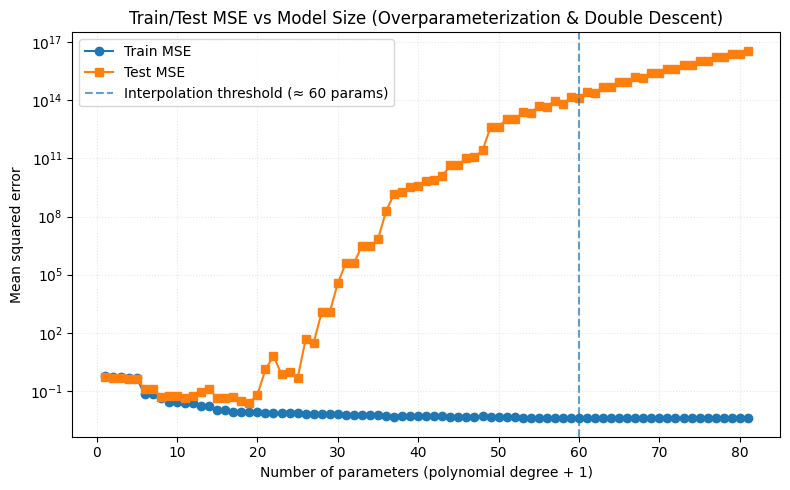

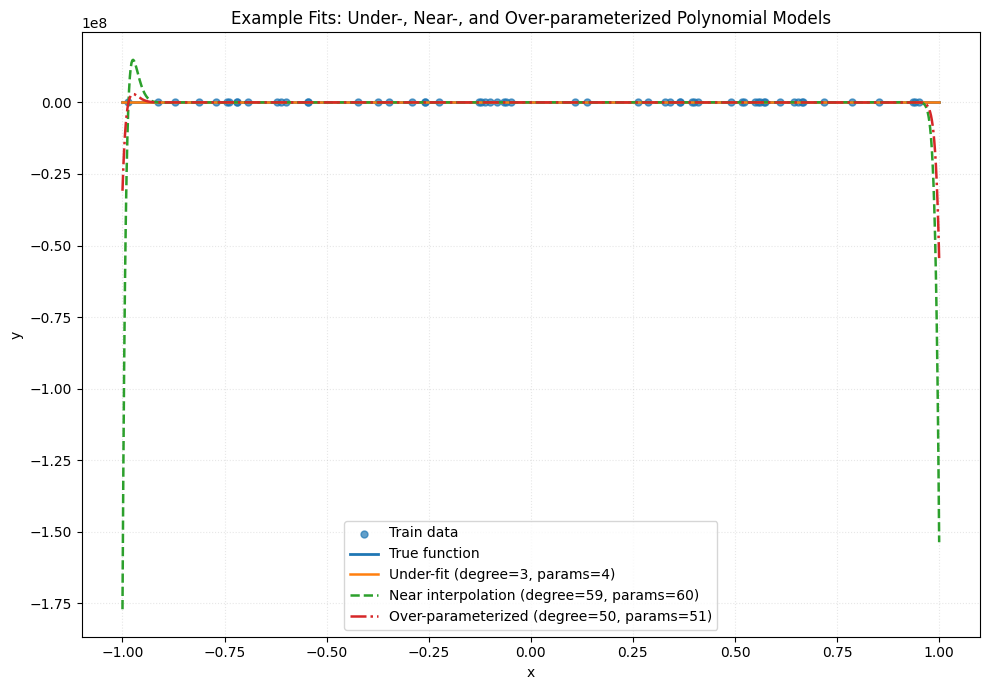

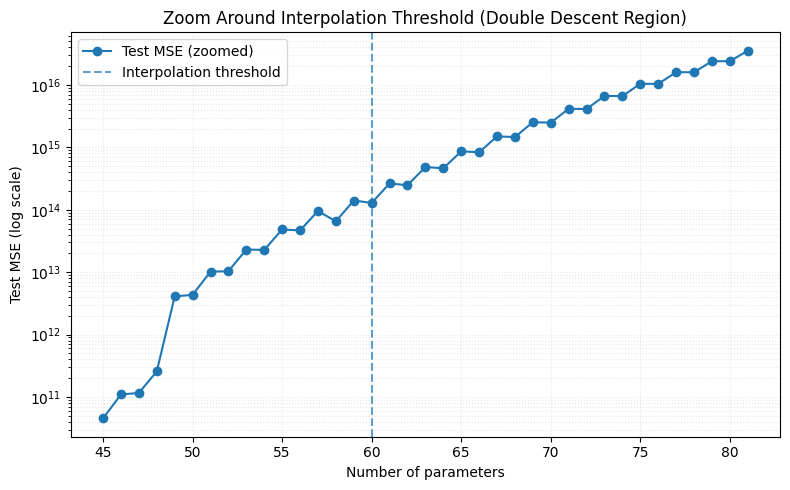

In [1]:
# Overparameterization & Double Descent Demo
# -----------------------------------------
# This notebook cell:
# 1. Generates a noisy 1D regression dataset.
# 2. Fits polynomial regression models with increasing degree (model size).
# 3. Uses least-squares (minimum-norm) solutions, which can interpolate when #params >= #data.
# 4. Plots train/test MSE vs. number of parameters, showing a double-descent shape.
# 5. Visualizes example fits for under-, near-, and over-parameterized regimes.
# 6. Prints a summary table for report use.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------
# 1. Generate synthetic data
# -----------------------------
rng = np.random.default_rng(42)

# True function
def f_true(x):
    # moderately smooth but nonlinear target
    return np.sin(2 * np.pi * x) + 0.3 * np.cos(5 * np.pi * x)

# Data settings
N_TRAIN = 60   # number of training points
N_TEST  = 1000 # dense test grid for smooth curves
NOISE_STD = 0.15

# Training data
x_train = rng.uniform(-1.0, 1.0, size=N_TRAIN)
y_train = f_true(x_train) + rng.normal(0.0, NOISE_STD, size=N_TRAIN)

# Test data (sorted for smoother plotting)
x_test = np.linspace(-1.0, 1.0, N_TEST)
y_test = f_true(x_test)

# -----------------------------
# 2. Design matrix builder
# -----------------------------
def poly_design_matrix(x, degree):
    """
    Build polynomial design matrix up to given degree.
    Degree d -> (d+1) parameters including bias term.
    Φ_ij = x_i^j for j=0..degree
    """
    x = np.asarray(x)
    powers = np.arange(degree + 1)
    return x[:, None] ** powers[None, :]

# -----------------------------
# 3. Sweep model sizes
# -----------------------------
max_degree = 80  # maximum polynomial degree; parameters = degree+1
degrees = np.arange(0, max_degree + 1)   # includes constant-only model
n_params_list = degrees + 1

train_mse = []
test_mse  = []

# store some example predictions for visualization later
example_degrees = {}  # will fill with: {'under': d_small, 'critical': d_near_n, 'over': d_large}
d_under = 3                       # a small, clearly under-parameterized model
d_critical = N_TRAIN - 1          # degree where #params ~= #train (interpolation threshold)
d_over = 50                       # heavily overparameterized

predictions_examples = {}

for d in degrees:
    # Design matrices
    Phi_train = poly_design_matrix(x_train, d)
    Phi_test  = poly_design_matrix(x_test, d)

    # Minimum-norm least squares solution (works in both under- and over-parameterized regimes)
    theta, *_ = np.linalg.lstsq(Phi_train, y_train, rcond=None)

    # Predictions
    y_pred_train = Phi_train @ theta
    y_pred_test  = Phi_test @ theta

    # MSE
    mse_train = np.mean((y_pred_train - y_train) ** 2)
    mse_test  = np.mean((y_pred_test - y_test) ** 2)

    train_mse.append(mse_train)
    test_mse.append(mse_test)

    # Store example fits for selected degrees
    if d in [d_under, d_critical, d_over]:
        predictions_examples[d] = (x_test.copy(), y_pred_test.copy())

train_mse = np.array(train_mse)
test_mse  = np.array(test_mse)

# -----------------------------
# 4. Summary table (for report)
# -----------------------------
# Select a few representative degrees to keep table compact
summary_degrees = [0, 3, 10, d_critical, d_over, max_degree]
summary_rows = []

for d in summary_degrees:
    idx = np.where(degrees == d)[0][0]
    n_params = n_params_list[idx]
    summary_rows.append({
        "degree": d,
        "n_params": n_params,
        "train_mse": train_mse[idx],
        "test_mse": test_mse[idx]
    })

summary_df = pd.DataFrame(summary_rows)
print("=== Compact Summary of Polynomial Models ===")
print(summary_df.to_string(index=False))

# -----------------------------
# 5. Plot: Double Descent Curve
# -----------------------------
plt.figure(figsize=(8, 5))
plt.plot(n_params_list, train_mse, marker='o', linestyle='-', label="Train MSE")
plt.plot(n_params_list, test_mse,  marker='s', linestyle='-', label="Test MSE")

# mark interpolation threshold (#params ≈ #training samples)
interp_idx = np.argmin(np.abs(n_params_list - N_TRAIN))
plt.axvline(n_params_list[interp_idx], linestyle='--', alpha=0.7,
            label=f"Interpolation threshold (≈ {N_TRAIN} params)")

plt.xlabel("Number of parameters (polynomial degree + 1)")
plt.ylabel("Mean squared error")
plt.yscale("log")  # log scale makes double-descent shape clearer
plt.title("Train/Test MSE vs Model Size (Overparameterization & Double Descent)")
plt.legend()
plt.grid(True, which="both", linestyle=":", alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# 6. Plot: Example Fits
# -----------------------------
plt.figure(figsize=(10, 7))

# sort training data for nicer display
sort_idx = np.argsort(x_train)
x_train_sorted = x_train[sort_idx]
y_train_sorted = y_train[sort_idx]

plt.scatter(x_train, y_train, s=25, alpha=0.7, label="Train data")

# true function
plt.plot(x_test, y_test, linewidth=2.0, label="True function")

# under-parameterized
if d_under in predictions_examples:
    x_ex, y_ex = predictions_examples[d_under]
    plt.plot(x_ex, y_ex, linestyle='-', linewidth=1.8,
             label=f"Under-fit (degree={d_under}, params={d_under+1})")

# near interpolation threshold
if d_critical in predictions_examples:
    x_ex, y_ex = predictions_examples[d_critical]
    plt.plot(x_ex, y_ex, linestyle='--', linewidth=1.8,
             label=f"Near interpolation (degree={d_critical}, params={d_critical+1})")

# over-parameterized
if d_over in predictions_examples:
    x_ex, y_ex = predictions_examples[d_over]
    plt.plot(x_ex, y_ex, linestyle='-.', linewidth=1.8,
             label=f"Over-parameterized (degree={d_over}, params={d_over+1})")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Example Fits: Under-, Near-, and Over-parameterized Polynomial Models")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# 7. Optional: zoom near interpolation region
# -----------------------------
plt.figure(figsize=(8, 5))
mask = (n_params_list >= N_TRAIN - 15) & (n_params_list <= N_TRAIN + 25)
plt.plot(n_params_list[mask], test_mse[mask], marker='o', linestyle='-',
         label="Test MSE (zoomed)")
plt.axvline(N_TRAIN, linestyle='--', alpha=0.7, label="Interpolation threshold")
plt.xlabel("Number of parameters")
plt.ylabel("Test MSE (log scale)")
plt.yscale("log")
plt.title("Zoom Around Interpolation Threshold (Double Descent Region)")
plt.legend()
plt.grid(True, which="both", linestyle=":", alpha=0.3)
plt.tight_layout()
plt.show()
